<a href="https://colab.research.google.com/github/qxygxt/Food11-Classification/blob/main/Food11_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using pretrained DenseNet-121 to classify 11 categories of food images**

## **1 Prepare Dataset**

Download dataset from https://www.kaggle.com/datasets/trolukovich/food11-image-dataset and upload zip to Google Drive, then unzip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive (1).zip' -d '/content/drive/MyDrive/Food11-Data'

##**2 Import Packages**

In [3]:
# Import necessary packages.
import os
import time
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from PIL import Image
from torch import nn, optim
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.models import densenet121
from tqdm import tqdm
from sklearn.metrics import classification_report

##**3 Configuration**

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if DEVICE =='cuda':
    torch.cuda.manual_seed_all(1234)
print(DEVICE)

cuda


In [5]:
# For Data Processing
DATA_PATH = "/content/drive/MyDrive/Food11-Data"
TRAIN_PATH = os.path.join(DATA_PATH, "training")
VAL_PATH = os.path.join(DATA_PATH, "validation")
TEST_PATH = os.path.join(DATA_PATH, "evaluation")

CLASSES = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat", "Noodles-Pasta", "Rice", "Seafood", "Soup", "Vegetable-Fruit"]

IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# For Training
epochs = 20
batch_size = 50
lr = 0.001

PLOT_PATH = os.path.join("./", "model_training.png")
MODEL_PATH = os.path.join("./", "food_classifier.pth")

##**4 Data Processing**

In [6]:
def get_dataloader(rootDir, transforms, bs, shuffle=True):
	# create a dataset and use it to create a data loader
	ds = datasets.ImageFolder(root=rootDir, transform=transforms)
	loader = DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=os.cpu_count(), pin_memory=True if DEVICE == "cuda" else False)
    
	# return a tuple of the dataset and the data loader
	return (ds, loader)

In [8]:
trainTansform = transforms.Compose([
	transforms.RandomResizedCrop(IMAGE_SIZE),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(90),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

testTransform = transforms.Compose([
	transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

# create data loaders
(trainDS, train_loader) = get_dataloader(TRAIN_PATH, transforms=trainTansform, bs=batch_size)
(valDS, val_loader) = get_dataloader(VAL_PATH, transforms=testTransform, bs=batch_size, shuffle=False)
(testDS, test_loader) = get_dataloader(TEST_PATH, transforms=testTransform, bs=batch_size, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

209
69
67


##**5 Create Model**

In [9]:
class FoodClassifier(nn.Module):
	def __init__(self, baseModel, numClasses):
		super(FoodClassifier, self).__init__()
        
		# initialize the base model and the classification layer
		self.baseModel = baseModel
		self.classifier = nn.Linear(baseModel.classifier.in_features, numClasses)
        
		# set the classifier of our base model to produce outputs from the last convolution block
		self.baseModel.classifier = nn.Identity()
        
    # we decorate the *forward()* method with *autocast()* to enable mixed-precision training in a distributed manner
	@autocast()
	def forward(self, x):
		# pass the inputs through the base model and then obtain the classifier outputs
		features = self.baseModel(x)
		logits = self.classifier(features)
        
		# return the classifier outputs
		return logits

In [10]:
# load up the DenseNet121 model
baseModel = densenet121(pretrained=True)

# loop over the modules of the model and if the module is batch norm, set it to non-trainable
for module, param in zip(baseModel.modules(), baseModel.parameters()):
	if isinstance(module, nn.BatchNorm2d):
		param.requires_grad = False
        
# initialize our custom model and flash it to the current device
model = FoodClassifier(baseModel, len(trainDS.classes))
model = model.to(DEVICE)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

##**6 Training**

In [12]:
# determine the number of GPUs we have
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

# determine the batch size based on the number of GPUs
BATCH_SIZE = batch_size * NUM_GPU
print(f"[INFO] using a batch size of {BATCH_SIZE}...")

[INFO] number of GPUs found: 1...
[INFO] using a batch size of 50...


In [13]:
# if we have more than one GPU then parallelize the model
if NUM_GPU > 1:
	model = nn.DataParallel(model)
    
# initialize loss function, optimizer, and gradient scaler
lossFunc = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = lr * NUM_GPU)
scaler = torch.cuda.amp.GradScaler(enabled=True)

# initialize a learning-rate (LR) scheduler to decay the it by a factor of 0.1 after every 10 epochs
lrScheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],	"val_acc": []}

In [15]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(epochs)):
	# set the model in training mode
	model.train()
    
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
    
	# initialize the number of correct predictions in the training and validation step
	trainCorrect = 0
	valCorrect = 0
    
	# loop over the training set
	for (x, y) in train_loader:
		with torch.cuda.amp.autocast(enabled=True):
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
            
			# perform a forward pass and calculate the training loss
			pred = model(x)
			loss = lossFunc(pred, y)
            
		# calculate the gradients
		scaler.scale(loss).backward()
		scaler.step(opt)
		scaler.update()
		opt.zero_grad()
        
		# add the loss to the total training loss so far and calculate the number of correct predictions
		totalTrainLoss += loss.item()
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
        
	# update our LR scheduler
	lrScheduler.step()
    
    # switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
        
		# loop over the validation set
		for (x, y) in val_loader:
			with torch.cuda.amp.autocast(enabled=True):
				# send the input to the device
				(x, y) = (x.to(DEVICE), y.to(DEVICE))
                
				# make the predictions and calculate the validation loss
				pred = model(x)
				totalValLoss += lossFunc(pred, y).item()
                
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
            
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
    
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(valDS)
    
    # update our training history
	H["train_loss"].append(avgTrainLoss)
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss)
	H["val_acc"].append(valCorrect)
    
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  5%|▌         | 1/20 [02:21<44:44, 141.27s/it]

[INFO] EPOCH: 1/20
Train loss: 0.856015, Train accuracy: 0.7178
Val loss: 0.863283, Val accuracy: 0.7405


 10%|█         | 2/20 [04:41<42:11, 140.63s/it]

[INFO] EPOCH: 2/20
Train loss: 0.742997, Train accuracy: 0.7590
Val loss: 0.746513, Val accuracy: 0.7551


 15%|█▌        | 3/20 [07:01<39:42, 140.15s/it]

[INFO] EPOCH: 3/20
Train loss: 0.714689, Train accuracy: 0.7649
Val loss: 0.609531, Val accuracy: 0.8160


 20%|██        | 4/20 [09:20<37:18, 139.93s/it]

[INFO] EPOCH: 4/20
Train loss: 0.687977, Train accuracy: 0.7807
Val loss: 0.777924, Val accuracy: 0.7563


 25%|██▌       | 5/20 [11:41<35:02, 140.14s/it]

[INFO] EPOCH: 5/20
Train loss: 0.632929, Train accuracy: 0.7942
Val loss: 0.652795, Val accuracy: 0.7825


 30%|███       | 6/20 [14:00<32:39, 139.98s/it]

[INFO] EPOCH: 6/20
Train loss: 0.590690, Train accuracy: 0.8078
Val loss: 0.535257, Val accuracy: 0.8309


 35%|███▌      | 7/20 [16:20<30:19, 139.96s/it]

[INFO] EPOCH: 7/20
Train loss: 0.579541, Train accuracy: 0.8089
Val loss: 0.608478, Val accuracy: 0.8125


 40%|████      | 8/20 [18:41<28:01, 140.12s/it]

[INFO] EPOCH: 8/20
Train loss: 0.561022, Train accuracy: 0.8181
Val loss: 0.601076, Val accuracy: 0.8163


 45%|████▌     | 9/20 [21:01<25:40, 140.03s/it]

[INFO] EPOCH: 9/20
Train loss: 0.544711, Train accuracy: 0.8224
Val loss: 0.508612, Val accuracy: 0.8429


 50%|█████     | 10/20 [23:20<23:18, 139.90s/it]

[INFO] EPOCH: 10/20
Train loss: 0.418231, Train accuracy: 0.8672
Val loss: 0.370194, Val accuracy: 0.8813


 55%|█████▌    | 11/20 [25:40<20:59, 139.93s/it]

[INFO] EPOCH: 11/20
Train loss: 0.362799, Train accuracy: 0.8818
Val loss: 0.350064, Val accuracy: 0.8834


 60%|██████    | 12/20 [27:59<18:37, 139.64s/it]

[INFO] EPOCH: 12/20
Train loss: 0.350108, Train accuracy: 0.8875
Val loss: 0.345296, Val accuracy: 0.8892


 65%|██████▌   | 13/20 [30:19<16:17, 139.70s/it]

[INFO] EPOCH: 13/20
Train loss: 0.316085, Train accuracy: 0.9005
Val loss: 0.329022, Val accuracy: 0.8942


 70%|███████   | 14/20 [32:40<14:00, 140.08s/it]

[INFO] EPOCH: 14/20
Train loss: 0.320244, Train accuracy: 0.8956
Val loss: 0.330015, Val accuracy: 0.8913


 75%|███████▌  | 15/20 [35:01<11:41, 140.27s/it]

[INFO] EPOCH: 15/20
Train loss: 0.307542, Train accuracy: 0.9011
Val loss: 0.326682, Val accuracy: 0.8948


 80%|████████  | 16/20 [37:21<09:21, 140.27s/it]

[INFO] EPOCH: 16/20
Train loss: 0.292832, Train accuracy: 0.9045
Val loss: 0.340945, Val accuracy: 0.8933


 85%|████████▌ | 17/20 [39:39<06:58, 139.58s/it]

[INFO] EPOCH: 17/20
Train loss: 0.285070, Train accuracy: 0.9070
Val loss: 0.336563, Val accuracy: 0.8889


 90%|█████████ | 18/20 [41:57<04:38, 139.24s/it]

[INFO] EPOCH: 18/20
Train loss: 0.278675, Train accuracy: 0.9114
Val loss: 0.329922, Val accuracy: 0.8913


 95%|█████████▌| 19/20 [44:16<02:18, 138.96s/it]

[INFO] EPOCH: 19/20
Train loss: 0.266081, Train accuracy: 0.9181
Val loss: 0.315635, Val accuracy: 0.8991


100%|██████████| 20/20 [46:34<00:00, 139.73s/it]

[INFO] EPOCH: 20/20
Train loss: 0.257631, Train accuracy: 0.9180
Val loss: 0.308569, Val accuracy: 0.8997
[INFO] total time taken to train the model: 2794.59s


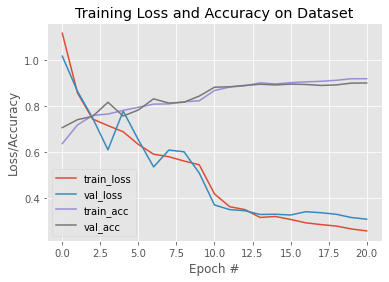

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

# serialize the model state to disk
torch.save(model.state_dict(), MODEL_PATH)

##**7 Testing**

In [17]:
print("[INFO] testing network...")
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
    
	# initialize a list to store our predictions
	preds = []
    
	# loop over the test set
	for (x, _) in test_loader:
		# send the input to the device
		x = x.to(DEVICE)
        
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
        
# generate a classification report
print(classification_report(testDS.targets, preds, target_names=testDS.classes))

[INFO] testing network...
                 precision    recall  f1-score   support

          Bread       0.92      0.86      0.88       368
  Dairy product       0.88      0.82      0.85       148
        Dessert       0.86      0.89      0.87       500
            Egg       0.90      0.92      0.91       335
     Fried food       0.89      0.91      0.90       287
           Meat       0.92      0.92      0.92       432
  Noodles-Pasta       0.97      0.98      0.97       147
           Rice       0.97      0.91      0.94        96
        Seafood       0.94      0.91      0.93       303
           Soup       0.96      0.98      0.97       500
Vegetable-Fruit       0.95      0.97      0.96       231

       accuracy                           0.92      3347
      macro avg       0.92      0.91      0.92      3347
   weighted avg       0.92      0.92      0.92      3347

